In [1]:
import casadi as ca
import numpy as np

from parameter_estimator import ParameterEstimator

### Lotka–Volterra model

$$
\begin{aligned}
\dot{x}_1 &= \alpha\,x_1 - \beta\,x_1 x_2,\\
\dot{x}_2 &= \delta\,x_1 x_2 - \gamma\,x_2
\end{aligned}
$$

| parameter | value |
|-----------|-------|
| $\alpha$ | **0.8** |
| $\beta$  | **0.3** |
| $\delta$ | 0.4 |
| $\gamma$ | 0.6 |

Initial state $$x_1$(0)=10,\; $x_2$(0)=5$.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.00us (  1.57us)  10.83us (  1.55us)         7
       nlp_g  |   7.17ms (  1.02ms)   7.18ms (  1.03ms)         7
  nlp_grad_f  |  22.00us (  2.75us)  20.63us (  2.58us)         8
  nlp_hess_l  | 103.92ms ( 17.32ms) 103.92ms ( 17.32ms)         6
   nlp_jac_g  |  61.46ms (  7.68ms)  61.46ms (  7.68ms)         8
       total  | 175.07ms (175.07ms) 175.08ms (175.08ms)         1


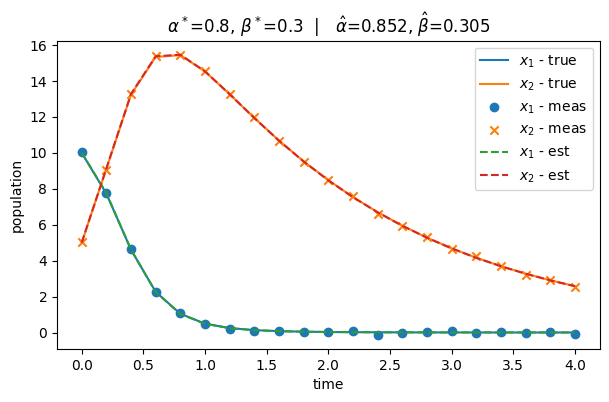

In [2]:
# ---------- 1. generate noisy  data ----------
true_alpha, true_beta = 0.8, 0.3
delta, gamma          = 0.4, 0.6
x1, x2 = ca.MX.sym("x1"), ca.MX.sym("x2")
alpha, beta = ca.MX.sym("alpha"), ca.MX.sym("beta")
ode_true = ca.vertcat(alpha * x1 - beta * x1 * x2,
                      delta * x1 * x2 - gamma * x2)
dae_true = {"x": ca.vertcat(x1, x2), "p": ca.vertcat(alpha, beta), "ode": ode_true}

F_true = ca.integrator("F", "cvodes", dae_true, 0.0, 0.2, {})
t_grid = np.arange(0.0, 4.0+1e-9, 0.2)
X = np.zeros((len(t_grid),2)); X[0] = (10,5)
for k in range(len(t_grid)-1):
    X[k+1] = F_true(x0=X[k], p=[true_alpha,true_beta])["xf"].full().ravel()
rng = np.random.default_rng(1)
X_meas = X + 0.05 * rng.standard_normal(X.shape)

# ---------- 2. define symbolic model ----------
p_vec = ca.MX.sym("p",2)
ode_est = ca.vertcat(p_vec[0]*x1 - p_vec[1]*x1*x2,
                     delta*x1*x2 - gamma*x2)
dae = {"x": ca.vertcat(x1,x2), "p": p_vec, "ode": ode_est}

# ---------- 3. estimate ----------
est = ParameterEstimator(dae, t_meas=t_grid, x_meas=X_meas,
                         p_init=[0.5,0.5], p_lb=[0,0], p_ub=[2,2],
                         options={"ipopt":{"print_level":0}})
sol = est.solve()
alpha_hat, beta_hat = sol["x"][-2:].full().ravel()

# ---------- 4. simulate with estimated parameters ----------
X_true = np.zeros_like(X)
X_est  = np.zeros_like(X)
X_true[0] = X_est[0] = X[0]

for k in range(len(t_grid) - 1):
    X_true[k+1] = F_true(x0=X_true[k], p=[true_alpha, true_beta])["xf"].full().ravel()
    X_est[k+1]  = F_true(x0=X_est[k],  p=[alpha_hat,  beta_hat ])["xf"].full().ravel()

# ---------- 5. plot ------------------------------------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(t_grid, X_true[:, 0], label=r"$x_1$ - true")
ax.plot(t_grid, X_true[:, 1], label=r"$x_2$ - true")

ax.scatter(t_grid, X_meas[:, 0], marker="o", label=r"$x_1$ - meas")
ax.scatter(t_grid, X_meas[:, 1], marker="x", label=r"$x_2$ - meas")

ax.plot(t_grid, X_est[:, 0], "--", label=r"$x_1$ - est")
ax.plot(t_grid, X_est[:, 1], "--", label=r"$x_2$ - est")

ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title(
    rf"$\alpha^*$={true_alpha}, $\beta^*$={true_beta}  |  "
    rf" $\hat{{\alpha}}$={alpha_hat:.3f}, $\hat{{\beta}}$={beta_hat:.3f}"
)
ax.legend()
plt.show()
